In [ ]:
!pip install aletheia-dnn
!pip install -U imbalanced-learn
!pip install -U scikit-learn
!pip install imblearn -U

In [2]:
import os
import gc
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/kaggle

In [4]:
import pickle
with open('train2.pkl', 'rb') as input:
    x_res = pickle.load(input)
    
with open('labels2.pkl', 'rb') as input:
    y_res = pickle.load(input)

In [5]:
x_res.drop(columns =['SK_ID_CURR','b_SK_ID_BUREAU','p_SK_ID_PREV'],inplace = True)
fnames = x_res.columns.tolist()

In [6]:
y_res.value_counts()

TARGET
0         41373
1         33098
dtype: int64

In [7]:
X_train, X_val, y_train, y_val = train_test_split(x_res, y_res, test_size=0.04, random_state=42)

In [ ]:

import tensorflow as tf
from tensorflow import keras

metrics = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc')
          ]

ES = tf.keras.callbacks.EarlyStopping(monitor="val_auc",patience=20,restore_best_weights=True, mode='max', verbose=1)
Rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=10, min_lr=0.000001)
callbacks = [ES, Rlr]

model = keras.Sequential()
model.add(keras.layers.Dense(32,activation='relu',input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = metrics)
model.fit(
          x=X_train,
          y=y_train,
          epochs = 500,
          batch_size=512,
          validation_data =(X_val, y_val),
          callbacks=[ES, Rlr],
         )

In [9]:
from aletheia import *
coefs = [layer.kernel.numpy() for layer in model.layers]
intercepts = [layer.bias.numpy() for layer in model.layers]

clf = UnwrapperClassifier(coefs, intercepts,feature_names=fnames)
clf.fit(X_train, y_train)

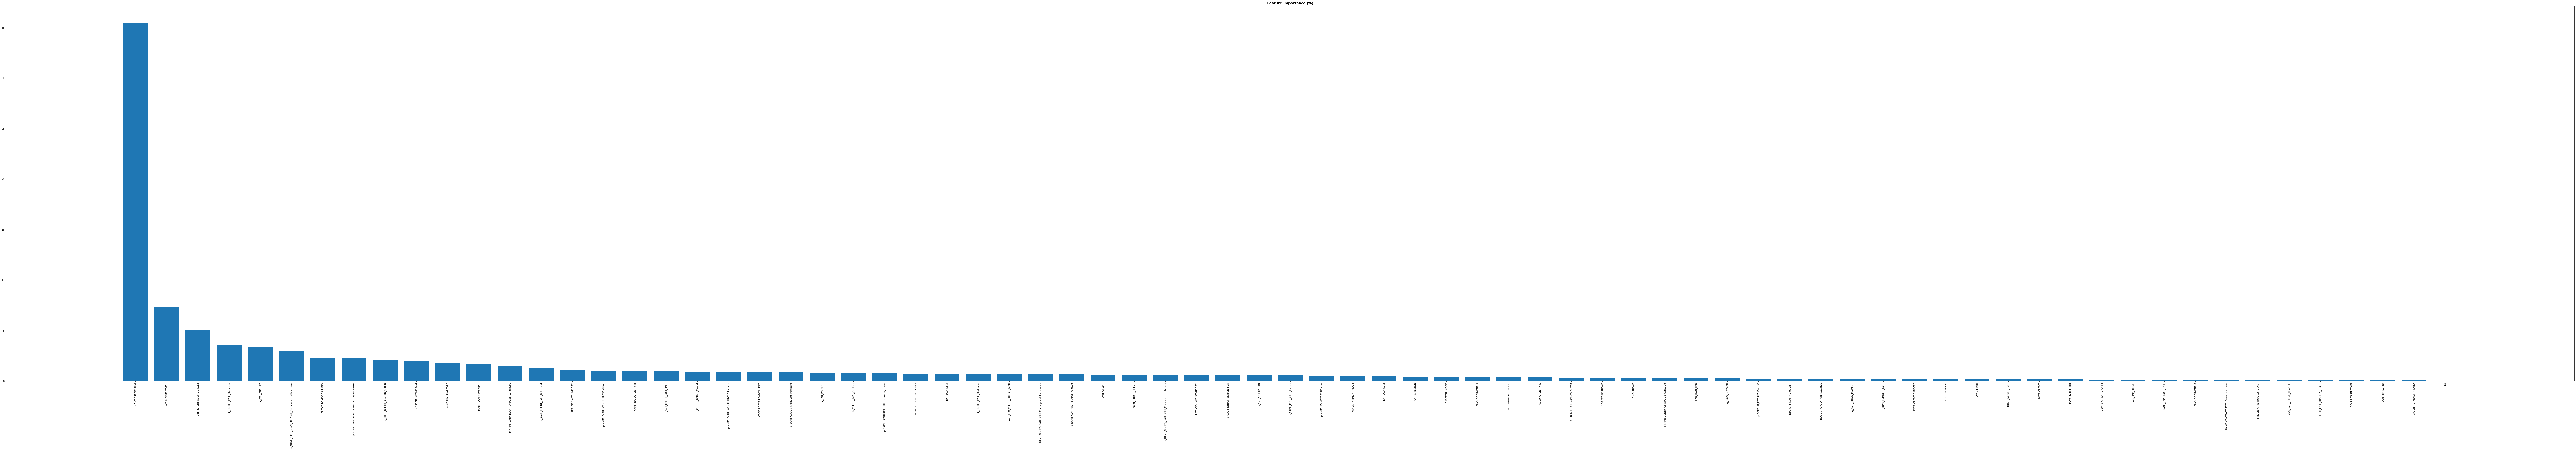

In [10]:
fig = clf.feature_importance_plot(figsize=(200, 30),include_b0=1,xlabel_rotation=90)


In [11]:
X_train=X_train.values
y_train = y_train.values


In [12]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
datanum = X_train.shape[0]
indices = np.arange(datanum)
idx1, idx2 = train_test_split(indices, test_size=0.2, random_state=0)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1


grid0 = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=coefs,
                                     biases=intercepts, 
                                     min_samples=50,
                                     n_neighbors=np.round(clf.nllms * 0.001).astype(int),
                                     refit_model=LogisticRegression(solver='sag',max_iter=2000,penalty='l2')),
                     
                                     param_grid={"n_clusters": [5,7, 9,11]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", error_score=np.nan, verbose=3)

grid1 = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=coefs,
                                     biases=intercepts, 
                                     min_samples=50,
                                     n_neighbors=np.round(clf.nllms * 0.001).astype(int),
                                     refit_model=LogisticRegression(solver='sag',max_iter=2000,penalty='l2')),
                     
                                     param_grid={"n_clusters": [12,13,14]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", error_score=np.nan, verbose=3)

grid2 = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=coefs,
                                     biases=intercepts, 
                                     min_samples=50,
                                     n_neighbors=np.round(clf.nllms * 0.001).astype(int),
                                     refit_model=LogisticRegression(solver='saga',max_iter=2000,penalty='l2')),
                                     param_grid={"n_clusters": [15,17,19]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", error_score=np.nan, verbose=3)

In [ ]:
grid0.fit(X_train, y_train)

In [ ]:
grid1.fit(X_train, y_train)

In [ ]:
grid2.fit(X_train, y_train)

In [18]:
res0 = pd.DataFrame(grid0.cv_results_)
res1 = pd.DataFrame(grid1.cv_results_)
res2 = pd.DataFrame(grid2.cv_results_)
res0 = pd.concat([res0,res1,res2])
result = res0.drop(columns=['rank_test_auc'])
result = result.reset_index()
result.drop(columns=['index'],inplace=True)
result.sort_values(by=['mean_test_auc'],ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_auc,mean_test_auc,std_test_auc
9,121.551665,0.0,27.627668,0.0,19,{'n_clusters': 19},0.885184,0.885184,0.0
8,120.218832,0.0,27.645167,0.0,17,{'n_clusters': 17},0.885142,0.885142,0.0
7,119.458418,0.0,27.643780,0.0,15,{'n_clusters': 15},0.884621,0.884621,0.0
4,115.281723,0.0,27.942187,0.0,12,{'n_clusters': 12},0.884510,0.884510,0.0
3,115.610371,0.0,27.643379,0.0,11,{'n_clusters': 11},0.884277,0.884277,0.0
6,115.509597,0.0,28.035995,0.0,14,{'n_clusters': 14},0.884269,0.884269,0.0
5,115.145003,0.0,27.670489,0.0,13,{'n_clusters': 13},0.884157,0.884157,0.0
2,115.752539,0.0,27.681626,0.0,9,{'n_clusters': 9},0.883715,0.883715,0.0
1,115.953274,0.0,27.638084,0.0,7,{'n_clusters': 7},0.883026,0.883026,0.0
0,114.927356,0.0,28.200103,0.0,5,{'n_clusters': 5},0.882632,0.882632,0.0


In [19]:
clf_merge = grid2.best_estimator_
clf_merge.summary()

,Count,Response Mean,Response Std,Local AUC,Global AUC
0,9332.0,0.138877,0.345818,0.723110,0.742992
1,7076.0,0.122386,0.327731,0.773746,0.786528
2,6549.0,0.193465,0.395014,0.710718,0.702463
3,5203.0,0.328849,0.469795,0.816464,0.829382
4,4276.0,0.546071,0.497873,0.840059,0.802587
5,4124.0,0.876334,0.329201,0.900705,0.841430
6,3908.0,0.481064,0.499641,0.774239,0.790883
7,3521.0,0.137177,0.344034,0.739323,0.790071
8,3437.0,0.408205,0.491501,0.835610,0.800000
9,3350.0,0.810448,0.391947,0.869721,0.840513


In [ ]:
clf_flatten  = clf_merge.flatten(refit_model=LogisticRegression(C=1e10),max_iter=2000)
clf_flatten.fit(X_train, y_train)

In [22]:
clf_prune = PrunerClassifier(unwrapper=clf, topk=np.sum(clf.count_llms > 10), refit_model=LogisticRegression())
clf_prune.fit(X_train, y_train)

In [ ]:
flnet = clf_flatten.flnet
flnet.fit(X_train,y_train)

In [ ]:
import tensorflow as tf
from tensorflow import keras

metrics = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc')
          ]

ES = tf.keras.callbacks.EarlyStopping(monitor="val_auc",patience=20,restore_best_weights=True, mode='max', verbose=1)
Rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=10, min_lr=0.000001)
callbacks = [ES, Rlr]

model1 = keras.Sequential()
model1.add(keras.layers.Dense(19,activation='relu',input_shape=(X_train.shape[1],)))
model1.add(keras.layers.Dense(1,activation='sigmoid'))
model1.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = metrics)
model1.fit(
          x=X_train,
          y=y_train,
          epochs = 500,
          batch_size=512,
          validation_data =(X_val, y_val),
          callbacks=[ES, Rlr],
         )

In [31]:
X_val= X_val.values
y_val = y_val.values

In [33]:
train_stat = pd.DataFrame(np.hstack([roc_auc_score(y_train, model.predict(X_train)),
           roc_auc_score(y_train, clf_prune.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, clf_merge.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, clf_flatten.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, flnet.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, model1.predict(X_train))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten","Flnet","Flat_DNN"], columns=["Train"]).T
test_stat =pd.DataFrame(np.hstack([roc_auc_score(y_val, model.predict(X_val)),
           roc_auc_score(y_val, clf_prune.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, clf_merge.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, clf_flatten.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, flnet.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, model1.predict(X_val))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten","Flnet","Flat_DNN"], columns=["Test"]).T
pd.concat([train_stat, test_stat]).round(4)

,ReLU-Net,Prune,Merge,Flatten,Flnet,Flat_DNN
Train,0.9115,0.5546,0.8927,0.9154,0.9154,0.8847
Test,0.9015,0.5613,0.8787,0.9046,0.9046,0.8775
